# 📌 라이브러리 임포트 

#### 1. 환경 설정
  - 회귀 분석 워크플로우용 파이썬 패키지 설치

#### 2. 설치할 패키지 및 역할

- `pandas`  
  - CSV 읽기·DataFrame 조작  
- `numpy`  
  - 수치 연산·결측값 처리  
- `matplotlib`  
  - 히스토그램·산점도 등 기본 시각화  
- `seaborn`  
  - 히트맵·박스플롯 등 고급 시각화  
- `statsmodels`  
  - Q–Q Plot 통한 정규성 시각화  
- `scipy`  
  - Shapiro–Wilk 등 통계 검정 함수  
- `scikit-learn`  
  - 전처리·파이프라인·모델 학습·튜닝·평가  

#### 3. 설치 명령어 (pip)
pip install --upgrade \
    pandas \
    numpy \
    matplotlib \
    seaborn \
    statsmodels \
    scipy \
    scikit-learn


In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# — 경고 무시 설정 ——————————————————————————————————————————————
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# — 데이터 로드·조작 ——————————————————————————————————————————————
import pandas as pd           # CSV 읽기 및 DataFrame 조작
import numpy as np            # 수치 연산 및 결측값 처리

# — EDA 및 시각화 ——————————————————————————————————————————————
import matplotlib.pyplot as plt  # 히스토그램, 산점도 등 기본 시각화
import seaborn as sns            # 히트맵, 박스플롯 등 고급 시각화
import statsmodels.api as sm     # Q–Q Plot을 통한 정규성 시각화
from scipy.stats import shapiro  # Shapiro–Wilk 정규성 검정

# — 전처리 & 파이프라인 구성 ——————————————————————————————————————
from sklearn.impute import SimpleImputer       # 결측치 대체 (mean, most_frequent)
from sklearn.preprocessing import StandardScaler  # 수치형 변수 Z-score 정규화
from sklearn.pipeline import Pipeline            # 전처리 + 모델 파이프라인

# — 모델 선택 & 튜닝 ——————————————————————————————————————————————
from sklearn.model_selection import train_test_split  # 학습/테스트 데이터 분할
from sklearn.model_selection import GridSearchCV      # 하이퍼파라미터 그리드 탐색

# — 회귀 모델 ——————————————————————————————————————————————————————
from sklearn.linear_model import LinearRegression  # 기본 선형 회귀
from sklearn.linear_model import Ridge             # L2 규제 회귀
from sklearn.linear_model import Lasso             # L1 규제 회귀
from sklearn.tree import DecisionTreeRegressor     # 결정트리 회귀

# — 성능 평가 지표 ——————————————————————————————————————————————————
from sklearn.metrics import mean_squared_error  # RMSE 계산
from sklearn.metrics import mean_absolute_error # MAE 계산
from sklearn.metrics import r2_score            # 결정계수 (R²) 계산


## 📌 A.데이터셋 확인 및 CGPA

In [15]:
# CSV 파일 로드 및 기본 정보 확인
data = pd.read_csv('Student Mental health.csv')
print("원본 데이터셋 크기:", data.shape)   # (샘플 수, 변수 수) 출력
print(data.head())                          # 상위 5개 행 확인

# CGPA 구간 → 중앙값 수치로 변환 함수 정의
def cgpa_to_numeric(val):
    if pd.isna(val):
        return np.nan                       # 결측치 있으면 NaN 반환
    v = val.strip()                         # 문자열 양쪽 공백 제거
    # 구간별 중앙값 매핑
    if v.startswith('0'):    
        return 1.0                          # "0 – 1.99" 중앙값
    if '2.00' in v:          
        return 2.25                         # "2.00 – 2.49" 중앙값
    if '2.50' in v:          
        return 2.75                         # "2.50 – 2.99" 중앙값
    if '3.00' in v:          
        return 3.25                         # "3.00 – 3.49" 중앙값
    if '3.50' in v:          
        return 3.75                         # "3.50 – 4.00" 중앙값
    return np.nan                           # 예상치 못한 값은 NaN 처리

# CGPA_numeric 컬럼 생성 및 결측 비율 출력
data['CGPA_numeric'] = data['What is your CGPA?'].apply(cgpa_to_numeric)
print("CGPA_numeric 결측 비율:", data['CGPA_numeric'].isna().mean())

원본 데이터셋 크기: (101, 11)
        Timestamp Choose your gender   Age What is your course?  \
0  8/7/2020 12:02             Female  18.0          Engineering   
1  8/7/2020 12:04               Male  21.0    Islamic education   
2  8/7/2020 12:05               Male  19.0                  BIT   
3  8/7/2020 12:06             Female  22.0                 Laws   
4  8/7/2020 12:13               Male  23.0         Mathemathics   

  Your current year of Study What is your CGPA? Marital status  \
0                     year 1        3.00 - 3.49             No   
1                     year 2        3.00 - 3.49             No   
2                     Year 1        3.00 - 3.49             No   
3                     year 3        3.00 - 3.49            Yes   
4                     year 4        3.00 - 3.49             No   

  Do you have Depression? Do you have Anxiety? Do you have Panic attack?  \
0                     Yes                   No                       Yes   
1                      No 

## 📌 B.데이터 전처리 및 탐색적 분석 (EDA)

### 범주형 변수 처리

In [16]:
# 'Your current year of Study' 문자열 통일 및 정제
#    - 대소문자·공백·단어 순서 불일치 해결
data['Study_Year_Str'] = (
    data['Your current year of Study'].astype(str)
        .str.strip()                               # 앞뒤 공백 제거
        .str.lower()                               # 모두 소문자로
        .str.replace(r'\s+', ' ', regex=True)      # 연속 공백 단일 공백으로
        .str.replace('year', 'Year')               # 'year'→'Year' 통일
        .str.title()                               # 단어별 첫글자 대문자
)

# 순서형 변수(학년) → 정수 매핑 (Ordinal Encoding)
#    - 모델이 학년 순서를 인식하도록 1~4로 변환
data['Study_Year'] = data['Study_Year_Str'].map({
    'Year 1': 1,
    'Year 2': 2,
    'Year 3': 3,
    'Year 4': 4
})

# 학년 원-핫 인코딩 (One-Hot Encoding)
#    - drop_first=False로 모든 학년 컬럼 유지 (나중에 다중공선성 확인 후 선택)
year_dummies = pd.get_dummies(
    data['Study_Year_Str'], 
    prefix='Year', 
    drop_first=False
)
#    - 컬럼명 'Year_Year_X' → 'Year_X' 로 간소화
year_dummies.columns = [
    c.replace('Year_Year_', 'Year_') 
    for c in year_dummies.columns
]
#    - 원본 데이터프레임에 추가
data = pd.concat([data, year_dummies], axis=1)

# 범주형 변수 인코딩: 성별 및 전공
#    - drop_first=True로 기준 카테고리 제거하여 dummy trap 방지
data = pd.get_dummies(
    data,
    columns=['Choose your gender', 'What is your course?'],
    drop_first=True
)

# 이진 질문(Depression, Anxiety 등) 원-핫 인코딩
#    - Yes/No 응답을 0/1로 변환, drop_first=True로 'No' 기준
binary_questions = [
    'Do you have Depression?',
    'Do you have Anxiety?',
    'Do you have Panic attack?',
    'Marital status',
    'Did you seek any specialist for a treatment?'
]
data = pd.get_dummies(
    data,
    columns=binary_questions,
    drop_first=True
)
# 새로 생성된 '..._Yes' 피처 목록 저장
binary_feats = [q + '_Yes' for q in binary_questions]

### 결측치 처리

In [17]:
# 결측치 처리
#  - 수치형 변수(['Age','Study_Year','CGPA_numeric']) 결측치 → 평균(mean) 대체
num_cols = ['Age', 'Study_Year', 'CGPA_numeric']
num_imputer = SimpleImputer(strategy='mean')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

#  - 범주형 변수(object dtype 전체) 결측치 → 최빈값(most_frequent) 대체
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

### 스케일링

In [18]:
# 스케일링
#  - 수치형 변수(['Age', 'Study_Year', 'CGPA_numeric']) 표준화 수행
#    * 평균이 0, 표준편차가 1이 되도록 변환
#    * 변수별 단위·범위 차이를 제거하여 회귀 계수 비교 용이
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

### EDA 시각화

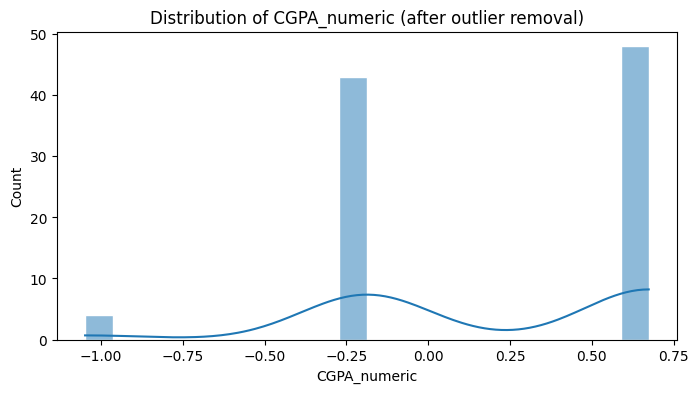

Shapiro–Wilk p-value: 0.000


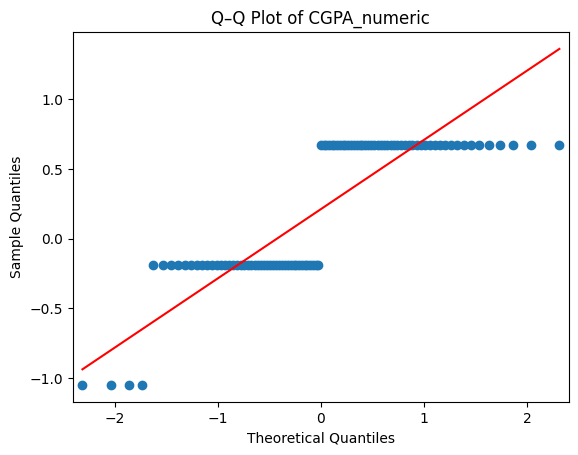

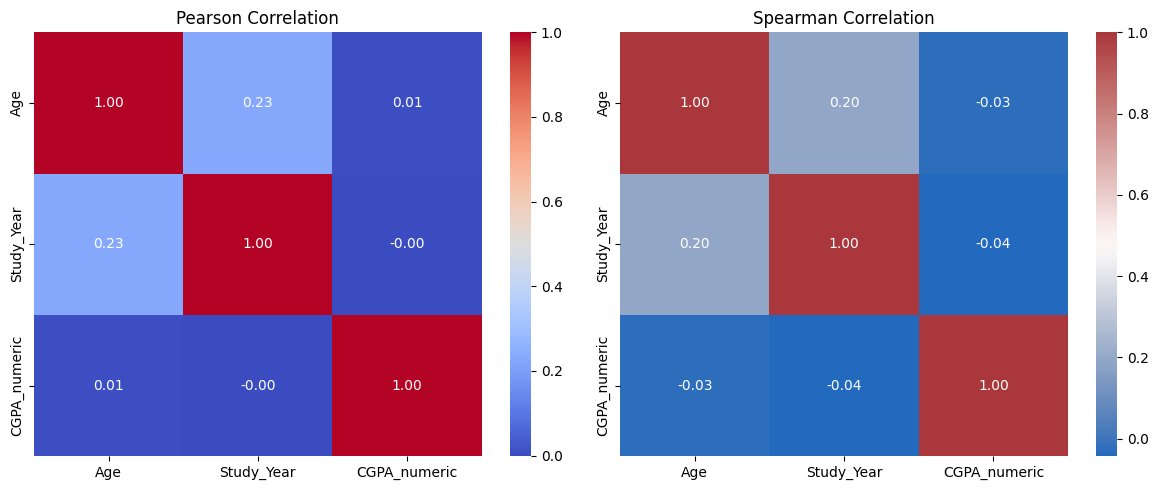

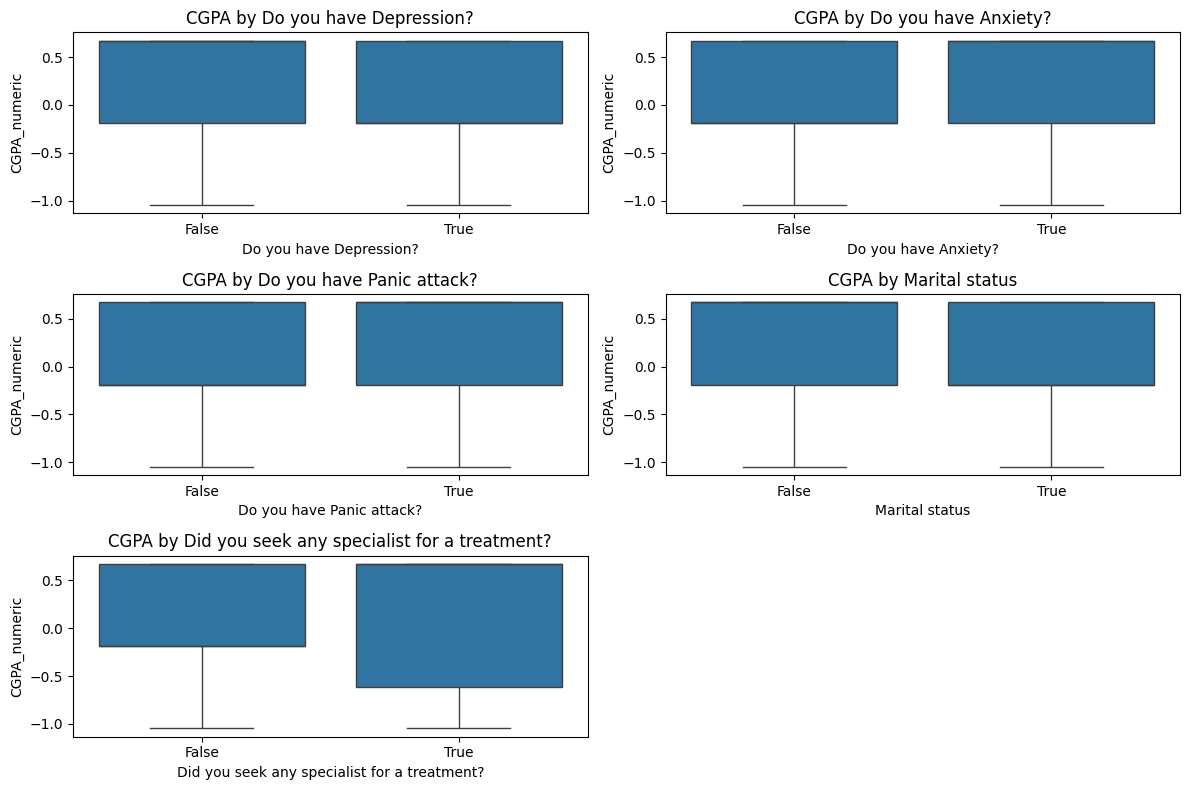

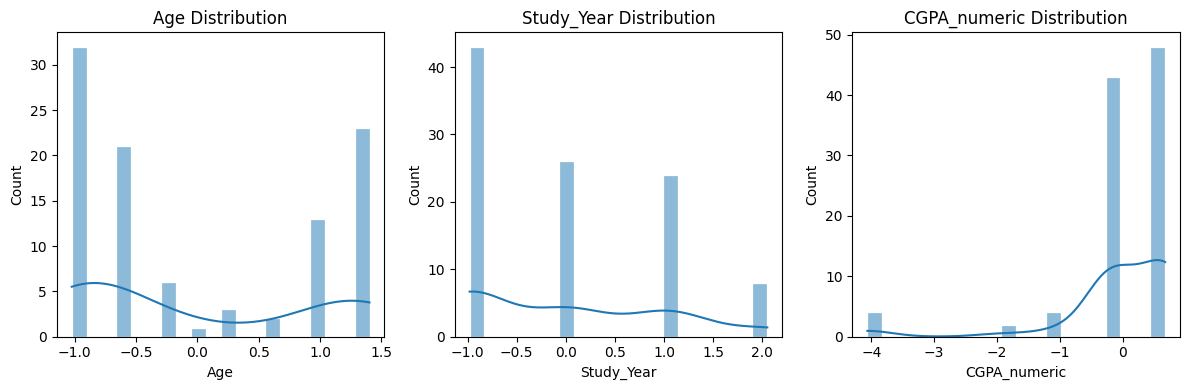

In [19]:
# EDA에 사용할 컬럼 선택 및 이상치 제거 (IQR 기준)
keep_cols = ['Age','Study_Year','CGPA_numeric'] + list(year_dummies.columns) + binary_feats
eda = data[keep_cols].copy()

# IQR 계산
Q1, Q3 = eda['CGPA_numeric'].quantile([0.25, 0.75])
IQR = Q3 - Q1
# IQR 범위 내 값만 남김
eda = eda.query('(@Q1 - 1.5*@IQR) <= CGPA_numeric <= (@Q3 + 1.5*@IQR)')

# CGPA_numeric 분포 (히스토그램 + KDE)
plt.figure(figsize=(8,4))
sns.histplot(
    eda['CGPA_numeric'],     # 이상치 제거된 CGPA_numeric
    kde=True,                # 커널 밀도 추정 곡선 추가
    bins=20,                 # 막대 개수
    edgecolor='w'            # 막대 테두리 색
)
plt.title("Distribution of CGPA_numeric (after outlier removal)")
plt.xlabel("CGPA_numeric")
plt.ylabel("Count")
plt.show()

# 정규성 검정 및 Q–Q 플롯
stat, p = shapiro(eda['CGPA_numeric'])
print(f"Shapiro–Wilk p-value: {p:.3f}")  # p > 0.05 이면 정규성 가정 통과

sm.qqplot(
    eda['CGPA_numeric'],     # 데이터 포인트
    line='s'                 # 대각선 참조선 그리기
)
plt.title("Q–Q Plot of CGPA_numeric")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# 숫자형 변수 상관관계 Heatmap (Pearson, Spearman)
numeric_feats = ['Age','Study_Year','CGPA_numeric']
pearson = eda[numeric_feats].corr(method='pearson')
spearman = eda[numeric_feats].corr(method='spearman')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(
    pearson, annot=True, fmt='.2f', cmap='coolwarm'
)
plt.title("Pearson Correlation")

plt.subplot(1,2,2)
sns.heatmap(
    spearman, annot=True, fmt='.2f', cmap='vlag'
)
plt.title("Spearman Correlation")
plt.tight_layout()
plt.show()

# 이진 변수별 CGPA_numeric 박스플롯
plt.figure(figsize=(12,8))
for i, feat in enumerate(binary_feats, start=1):
    ax = plt.subplot((len(binary_feats)+1)//2, 2, i)
    sns.boxplot(
        x=feat,                 # 이진 변수 (예: Do you have Anxiety?_Yes)
        y='CGPA_numeric',       # 대상: CGPA_numeric
        data=eda,               # 이상치 제거 후 데이터
        showfliers=False        # 이상치 점표시 생략
    )
    ax.set_title(f"CGPA by {feat[:-4]}")  # '_Yes' 제거하여 제목 표시
    ax.set_xlabel(feat[:-4])
    ax.set_ylabel("CGPA_numeric")
plt.tight_layout()
plt.show()

# 숫자형 변수 히스토그램 (Age, Study_Year, CGPA_numeric)
numeric_feats = ['Age','Study_Year','CGPA_numeric']
plt.figure(figsize=(12,4))
for i, feat in enumerate(numeric_feats, start=1):
    ax = plt.subplot(1, len(numeric_feats), i)
    sns.histplot(
        data[feat],             # 전체 데이터의 각 특성
        kde=True,               # KDE 곡선 추가
        bins=20,                # 막대 개수
        edgecolor='w'
    )
    ax.set_title(f"{feat} Distribution")
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


## 📌 C.모델 구축 및 학습

### 데이터 분할

In [20]:
# 불필요 컬럼 제거 (Drop unused columns)
#   - Timestamp: 분석에 사용하지 않는 응답 시각 정보
#   - Your current year of Study / Study_Year_Str: 학년 정보는 Study_Year, Year_* 더미로 대체됨
#   - What is your CGPA?: 원본 구간 응답, CGPA_numeric으로 대체됨
drop_cols = [
    'Timestamp',
    'Your current year of Study',
    'Study_Year_Str',
    'What is your CGPA?'
]
clean = data.drop(columns=drop_cols, errors='ignore')

In [21]:
# 특성(features) 및 타겟(target) 설정
#    • 수치형 변수: Age, Study_Year
#    • 이진 변수: binary_feats 리스트 (Depression_Yes 등)
#    • 학년 더미: year_dummies.columns (Year_1, Year_2, …)
#    • 성별·전공 더미: 컬럼명이 'Choose your gender_' 또는 'What is your course?_' 로 시작
features = (
    ['Age', 'Study_Year']
    + binary_feats
    + list(year_dummies.columns)
    + [
        c for c in clean.columns
        if c.startswith('Choose your gender_')
        or c.startswith('What is your course?_')
      ]
)
X = clean[features]          # 모델 입력용 독립변수 행렬
y = clean['CGPA_numeric']    # 예측 대상 종속변수 벡터

# 데이터 분할(train/test)
#    • train_test_split 사용
#    • 학습용 80% / 테스트용 20% 비율 지정(test_size=0.2)
#    • random_state=42 로 재현성 확보
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### 파이프라인 및 모델 정의

In [22]:
# 4개 회귀 모델 파이프 라인 정의(Linear, Ridge, Lasso, DecisionTree)
pipelines = {
            'LinearRegression': Pipeline([
            ('scaler', StandardScaler()), # 수치형 변수 표준화
            ('model', LinearRegression()) # 기본 선형 회귀
        ]),
            'Ridge': Pipeline([
            ('scaler', StandardScaler()), # 수치형 변수 표준화
            ('model', Ridge(alpha=1.0)) # L2 규제 선형 회귀
        ]),
            'Lasso': Pipeline([
            ('scaler', StandardScaler()), # 수치형 변수 표준화
            ('model', Lasso(alpha=0.1)) # L1 규제 선형 회귀
        ]),
            'DecisionTree': Pipeline([
            ('model', DecisionTreeRegressor( # 결정 트리(스케일링 불필요)
            max_depth=5
        ))
        ])
            }

### 모델 학습

In [23]:
# 모델 학습
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f"{name} 학습 완료")

LinearRegression 학습 완료
Ridge 학습 완료
Lasso 학습 완료
DecisionTree 학습 완료


## 📌 D.성능평가


=== LinearRegression 평가 ===
RMSE: 1.317
MAE : 0.994
R²  : -0.803

=== Ridge 평가 ===
RMSE: 1.185
MAE : 0.786
R²  : -0.461

=== Lasso 평가 ===
RMSE: 1.048
MAE : 0.595
R²  : -0.142

=== DecisionTree 평가 ===
RMSE: 1.085
MAE : 0.667
R²  : -0.225


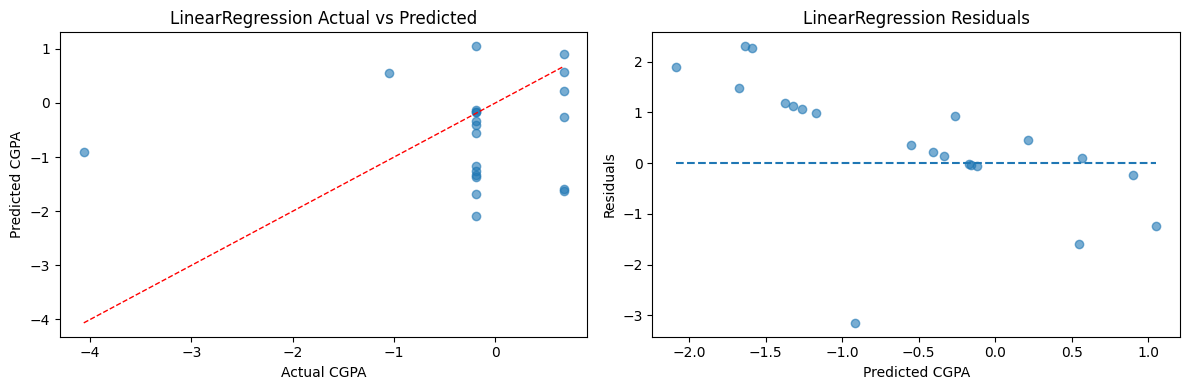

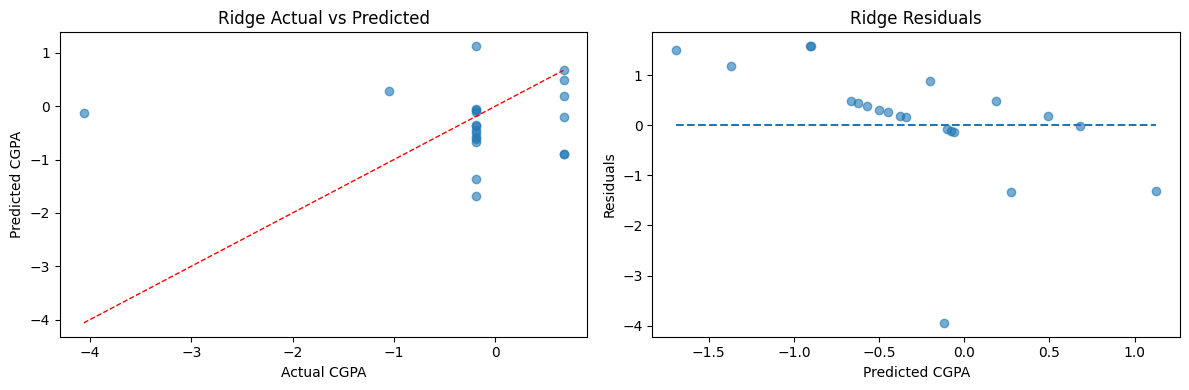

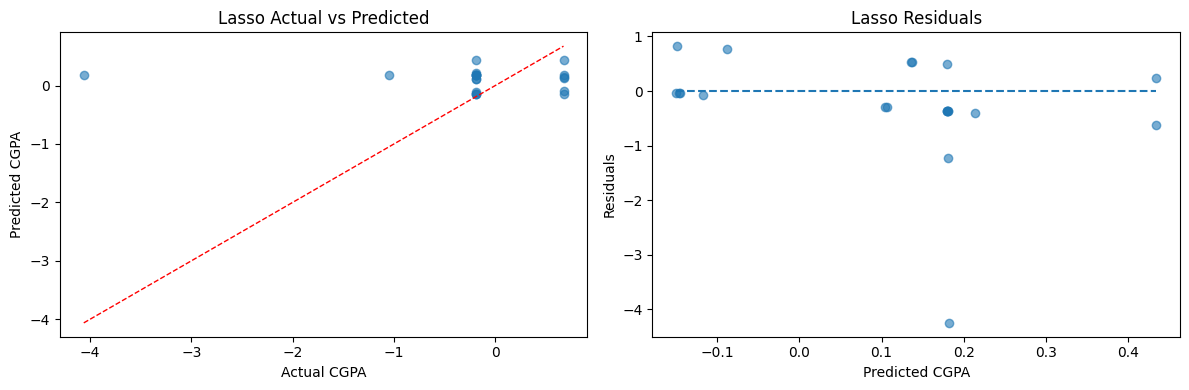

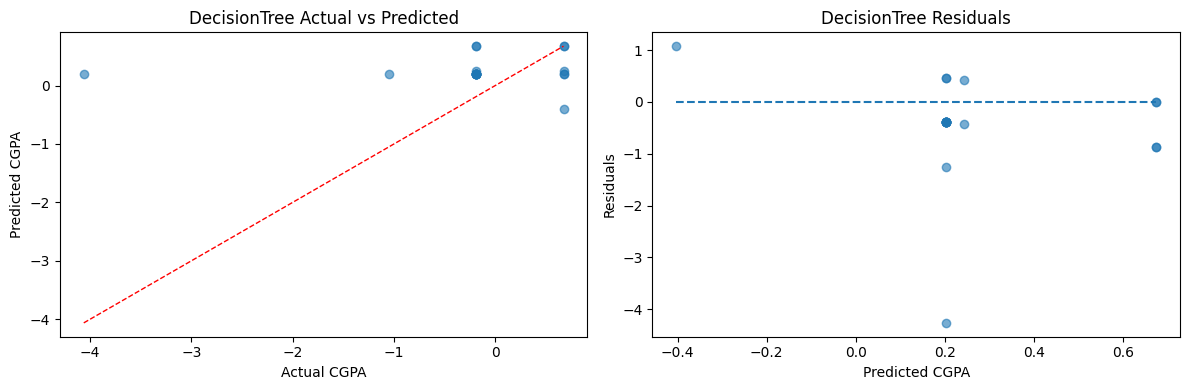

In [24]:
# 평가 지표 정의: RMSE, MAE, R²로 예측 오차 및 설명력 종합 평가
metrics = {
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'R2':  r2_score
}

# 모델별 성능 출력
for name, model in pipelines.items():
    y_pred = model.predict(X_test)                              # 테스트 세트 예측
    print(f"\n=== {name} 평가 ===")
    print(f"RMSE: {metrics['RMSE'](y_test, y_pred):.3f}")       # 예측 오차 분산 반영
    print(f"MAE : {metrics['MAE'](y_test, y_pred):.3f}")       # 절대 오차 직관적 이해
    print(f"R²  : {metrics['R2'](y_test, y_pred):.3f}")        # 모델 설명력 확인

# 시각화: 예측 정확도·잔차 분포로 모델 편향·분산 파악
for name, model in pipelines.items():
    y_pred    = model.predict(X_test)
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Actual vs Predicted: 완벽 예측선(45°)과 점 분포 비교
    axes[0].scatter(y_test, y_pred, alpha=0.6)
    axes[0].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 'r--', linewidth=1)
    axes[0].set(title=f"{name} Actual vs Predicted",
                xlabel="Actual CGPA", ylabel="Predicted CGPA")
    
    # Residual Plot: 잔차가 0 주변에 고르게 분포하는지 확인
    axes[1].scatter(y_pred, residuals, alpha=0.6)
    axes[1].hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='--')
    axes[1].set(title=f"{name} Residuals",
                xlabel="Predicted CGPA", ylabel="Residuals")
    
    plt.tight_layout()
    plt.show()

## 📌 E.하이퍼파라미터 튜닝

In [25]:
# 하이퍼파라미터 그리드 정의
param_grids = {
    'LinearRegression': {
        'model__fit_intercept': [True, False],    # 절편 사용 여부 탐색
        'model__positive':     [False, True],     # 계수 양수 제약 여부 탐색
    },
    'Ridge': {
        'model__alpha':  [0.01, 0.1, 1.0, 10.0, 100.0],  # L2 규제 강도 조절
        'model__solver': ['auto', 'svd', 'cholesky'],   # 해결 알고리즘 비교
    },
    'Lasso': {
        'model__alpha':    [0.001, 0.01, 0.1, 1.0],     # L1 규제 강도 조절
        'model__max_iter': [5000, 10000, 20000],        # 수렴을 위한 반복 횟수 확대
        'model__tol':      [1e-4, 1e-3, 1e-2],          # 허용 오차 완화 수준 탐색
    },
    'DecisionTree': {
        'model__max_depth':        [3, 5, 7, None],     # 최대 트리 깊이 조절
        'model__min_samples_leaf': [1, 2, 4],           # 리프 노드 최소 샘플 수
        'model__criterion':        ['squared_error', 'friedman_mse'],  # 분할 기준 비교
        'model__splitter':         ['best', 'random'],               # 분할 방식 비교
    }
}

best_estimators = {}

# GridSearchCV로 모델별 최적 파라미터 탐색
for name, pipe in pipelines.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=5,                                       # 5-폴드 교차검증
        scoring='neg_root_mean_squared_error',      # RMSE 기준으로 최적화
        n_jobs=-1                                  # 모든 CPU 코어 사용
    )
    grid.fit(X_train, y_train)                    # 학습 데이터로 그리드 탐색 수행

    # 3) 최적 파라미터 및 CV RMSE 출력
    print(f"\n{name} 최적 파라미터: {grid.best_params_}")
    print(f"{name} CV RMSE (best): {(-grid.best_score_):.3f}")

    best_estimators[name] = grid.best_estimator_  # 최적화된 모델 저장

# 테스트 세트에서 튜닝 전후 성능 비교
for name, est in best_estimators.items():
    y_pred = est.predict(X_test)                                 # 테스트 세트 예측
    rmse  = np.sqrt(mean_squared_error(y_test, y_pred))          # RMSE 계산
    mae   = mean_absolute_error(y_test, y_pred)                  # MAE 계산
    r2    = r2_score(y_test, y_pred)                             # R² 계산

    print(f"\n=== {name} 테스트 성능 ===")
    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")


LinearRegression 최적 파라미터: {'model__fit_intercept': False, 'model__positive': False}
LinearRegression CV RMSE (best): 1.336

Ridge 최적 파라미터: {'model__alpha': 100.0, 'model__solver': 'auto'}
Ridge CV RMSE (best): 0.885

Lasso 최적 파라미터: {'model__alpha': 1.0, 'model__max_iter': 5000, 'model__tol': 0.0001}
Lasso CV RMSE (best): 0.877

DecisionTree 최적 파라미터: {'model__criterion': 'friedman_mse', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__splitter': 'random'}
DecisionTree CV RMSE (best): 0.898

=== LinearRegression 테스트 성능 ===
RMSE: 1.331, MAE: 1.013, R²: -0.841

=== Ridge 테스트 성능 ===
RMSE: 1.019, MAE: 0.550, R²: -0.079

=== Lasso 테스트 성능 ===
RMSE: 1.003, MAE: 0.571, R²: -0.046

=== DecisionTree 테스트 성능 ===
RMSE: 1.029, MAE: 0.589, R²: -0.101


## 📌 F.최종 성능평가 및 시각화

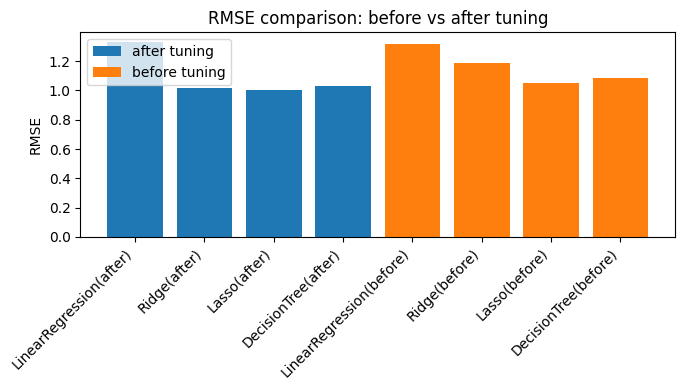

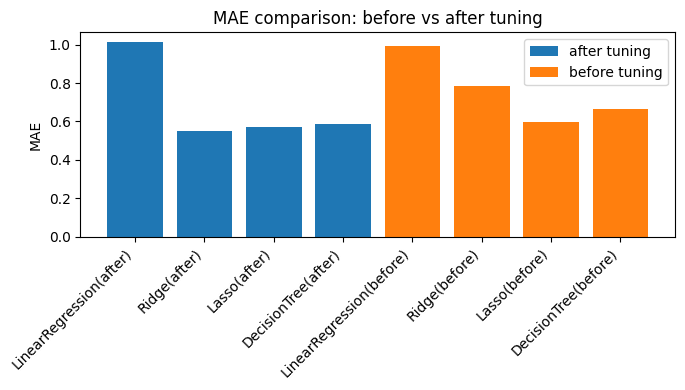

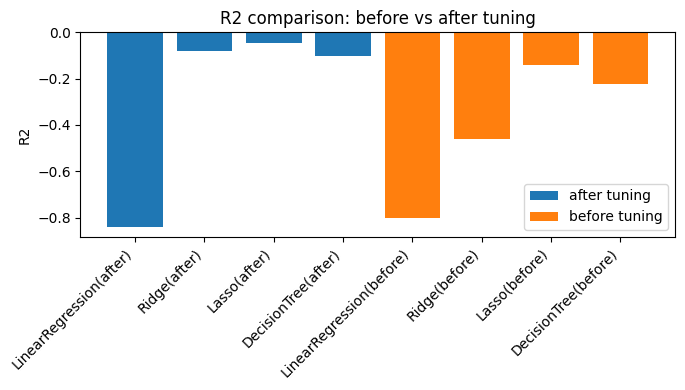

In [26]:
# 튜닝 전후 모델 성능 계산 및 리스트에 저장
results = []
# 튜닝 전 모델 성능
for name, model in pipelines.items():
    y_pred = model.predict(X_test)    # 테스트 데이터 예측
    results.append({
        'model': name,
        'type': 'before tuning',
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),  # RMSE 계산
        'MAE': mean_absolute_error(y_test, y_pred),           # MAE 계산
        'R2':  r2_score(y_test, y_pred)                       # R² 계산
    })
# 튜닝 후 모델 성능
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)    # 테스트 데이터 예측
    results.append({
        'model': name,
        'type': 'after tuning',
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2':  r2_score(y_test, y_pred)
    })
df_results = pd.DataFrame(results)    # 결과를 DataFrame으로 변환

# 성능 비교 그래프: before vs after
metrics = ['RMSE', 'MAE', 'R2']
for metric in metrics:
    fig, ax = plt.subplots(figsize=(7, 4))
    # before/after 그룹별로 막대 그리기
    for ttype, grp in df_results.groupby('type'):
        suffix = '(before)' if ttype == 'before tuning' else '(after)'
        ax.bar(
            grp['model'] + suffix,  # 모델명에 상태 접미사 추가
            grp[metric],             # 해당 지표 값
            label=ttype              # 범례에 before/after 표시
        )
    ax.set_ylabel(metric)                               # y축 레이블
    ax.set_title(f'{metric} comparison: before vs after tuning')  # 차트 제목
    ax.legend()                                         # 범례 표시
    plt.xticks(rotation=45, ha='right')                 # x축 라벨 회전 및 정렬
    plt.tight_layout()                                  # 레이아웃 자동 조정
    plt.show()                                          # 그래프 출력